<a href="https://colab.research.google.com/github/deshm084/-NanoGPT-Transformer-Language-Model/blob/main/Reinforcement%20Learning%20Agent%20(Policy%20Gradients).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install gymnasium
!pip install torch numpy matplotlib

Training RL Agent... (Watch the score go up!)
Episode 0	Average Score: 11.00
Episode 50	Average Score: 42.52
Episode 100	Average Score: 93.38
Episode 150	Average Score: 392.64
Episode 200	Average Score: 449.20
Solved in 231 episodes!


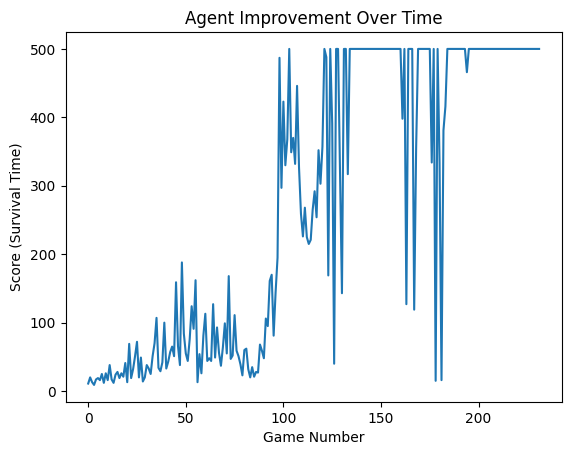

In [11]:
"""
Project: Reinforcement Learning (Policy Gradient)
Author: Sanskruti
Description: An AI Agent that learns to balance a pole (CartPole-v1)
             using the REINFORCE algorithm.
"""

import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# --- 1. The Brain (Policy Network) ---
# It takes the Game State (4 numbers) and outputs Action Probabilities (Left/Right)
class PolicyNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        # Softmax converts raw numbers into probabilities (sum to 1)
        return F.softmax(x, dim=1)

# --- 2. The Agent ---
class Agent:
    def __init__(self, env):
        self.env = env
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy = PolicyNetwork(env.observation_space.shape[0], env.action_space.n).to(self.device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=1e-2)

        # Memory to store what happened in a single game
        self.log_probs = []
        self.rewards = []

    def select_action(self, state):
        # Convert state to tensor
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)

        # Get probabilities from the Brain
        probs = self.policy(state)

        # Sample an action (Exploration vs Exploitation handled by probability distribution)
        m = torch.distributions.Categorical(probs)
        action = m.sample()

        # Save the log probability (needed for the math later)
        self.log_probs.append(m.log_prob(action))

        return action.item()

    def update_policy(self):
        # --- The Math: Discounted Rewards ---
        # Winning at step 100 is better than winning at step 1.
        # We "discount" future rewards so the agent cares about the NOW.
        R = 0
        returns = []
        gamma = 0.99 # Discount factor

        # Go backwards from the end of the game to the start
        for r in self.rewards[::-1]:
            R = r + gamma * R
            returns.insert(0, R)

        returns = torch.tensor(returns).to(self.device)
        # Normalize returns (makes training more stable)
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)

        # --- Policy Gradient Loss ---
        # Loss = -1 * (Log Probability of Action * Reward)
        # If Reward is High, we maximize the probability.
        policy_loss = []
        for log_prob, R in zip(self.log_probs, returns):
            policy_loss.append(-log_prob * R)

        # Backpropagation
        self.optimizer.zero_grad()
        policy_loss = torch.cat(policy_loss).sum()
        policy_loss.backward()
        self.optimizer.step()

        # Clear memory for next game
        self.log_probs = []
        self.rewards = []

# --- 3. Training Loop ---
env = gym.make('CartPole-v1') # Create the Game
agent = Agent(env)

print("Training RL Agent... (Watch the score go up!)")
scores = []

for episode in range(1000): # Play 1000 games
    state, _ = env.reset()
    ep_reward = 0

    while True:
        # 1. Agent chooses action
        action = agent.select_action(state)

        # 2. Environment reacts
        next_state, reward, done, truncated, _ = env.step(action)

        agent.rewards.append(reward)
        ep_reward += reward
        state = next_state

        if done or truncated:
            break

    # 3. Learn from the game
    agent.update_policy()
    scores.append(ep_reward)

    # Logging
    if episode % 50 == 0:
        print(f"Episode {episode}\tAverage Score: {np.mean(scores[-50:]):.2f}")

    # Early stopping if it masters the game (Score 495+)
    if np.mean(scores[-50:]) >= 495.0:
        print(f"Solved in {episode} episodes!")
        break

# --- 4. Plot Results ---
plt.plot(scores)
plt.title("Agent Improvement Over Time")
plt.xlabel("Game Number")
plt.ylabel("Score (Survival Time)")
plt.show()

env.close()